#### EMPEZAMOS EL PROYECTO DE MACHINE LEARNING, CON UN DATASET DEL SCRAPPING DE AIRBNB EN MADRID

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


from sklearn import metrics

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth',1000)

In [3]:
# CARGAMOS LOS DATOS A UTILIZAR

df_listings_detailed=pd.read_csv('data/listings_detailed.csv')

In [4]:
# ELIMINAMOS TODAS AQUELLAS COLUMNAS QUE NO NOS INTERESAN PARA ESTE PROYECTO

df_listings_detailed = df_listings_detailed.drop(columns=[
    'listing_url',
    'scrape_id',
    'last_scraped',
    'name',
    'picture_url',
    'host_id',
    'host_url',
    'host_name',
    # 'host_since',
    'host_location',
    'host_about',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'host_is_superhost',
    'host_thumbnail_url',
    'host_picture_url',
    'host_neighbourhood',
    'host_listings_count',
    'host_total_listings_count',
    'host_verifications',
    'host_has_profile_pic',
    'host_identity_verified',
    'bathrooms',
    'maximum_nights',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'calendar_updated',
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'calendar_last_scraped',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'first_review',
    'last_review',
    # 'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'license',
    'instant_bookable',
    # 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'neighborhood_overview',
    'minimum_nights',
    'neighbourhood',
    'neighbourhood_cleansed',
    'property_type'])
    

In [5]:
# REEMPLAZAMOS ELEMENTOS DE TEXTO PARA CONVERTIR TODAS LAS VARIABLES EN CATEGÓRICAS

df_listings_detailed['price'] = df_listings_detailed['price'].apply(lambda x: (x.replace('$','')))
df_listings_detailed['price'] = df_listings_detailed['price'].apply(lambda x: float(x.replace(',','')))

In [6]:
# OBTENEMOS EN ESTE CASO UNA NUEVA COLUMNA CON LA LONGITUD DEL TEXTO DE LA COLUMNA AMENITIES (A MAYOR LONGITUD, MAYOR CANTIDAD DE AMENITIES 
# Y POR TANTO MAYOR PRECIO)

df_listings_detailed['amenities_len']=len(df_listings_detailed['amenities'])

for i in range(len(df_listings_detailed['amenities'])):
    df_listings_detailed['amenities_len'].iloc[i] = len(df_listings_detailed['amenities'].iloc[i])

c:\Users\pieci\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
# ESTUDIAMOS LA VARIABLE ROOM TYPE, QUE CREEMOS QUE TENDRÁ BASTANTE PESO EN LA PREDICCIÓN DE NUEVOS VALORES

df_listings_detailed['room_type'].value_counts()

Entire home/apt    11314
Private room        7809
Shared room          329
Hotel room           166
Name: room_type, dtype: int64

In [8]:
# DECIDIMOS QUEDARNOS UNICAMENTE CON LOS DOS TIPOS DE ROOM TYPE CON MAS REPRESENTACIÓN

df_listings_detailed.drop(df_listings_detailed[df_listings_detailed['room_type']=='Shared room'].index, inplace=True)
df_listings_detailed.drop(df_listings_detailed[df_listings_detailed['room_type']=='Hotel room'].index, inplace=True)
# df_listings_detailed.drop(df_listings_detailed[df_listings_detailed['room_type']=='Private room'].index, inplace=True)

In [9]:
dict_room_type = {
                    'Private room':50,
                    'Entire home/apt':200,
                    # 'Shared room':2,
                    # 'Hotel room':3
                    }

df_listings_detailed['room_type_code'] = (df_listings_detailed['room_type'].replace(dict_room_type))

In [10]:
# TRANSFORMAMOS LA VARIABLE QUE REPRESENTA LOS DISTRITOS, GRACIAS A UN DATASET CON LOS BARRIOS Y SU VALOR DE €/M2 EN VIVIENDAS

df_barrios= pd.read_excel('data/Barrios LIMPIOS.xlsx')
df_barrios.set_index('Distrito', inplace = True)

df_listings_detailed['eur_distrito'] = (df_listings_detailed['neighbourhood_group_cleansed'].replace(df_barrios['€/m2']))
df_listings_detailed['eur_distrito'] = df_listings_detailed['eur_distrito'].apply(lambda x: float(x.replace(',',''))).astype(float)

In [11]:
# AÑADIMOS UNA NUEVA VARIABLE QUE REPRESENTA TAMBIÉN LOS DISTRITOS, EN ESTE CASO CREANDO UN RANKING CON EL VALOR MEDIO DE COSTE EN AIRBNB EN CADA UNO DE ELLOS

df_ranking= pd.read_excel('data/Barrios RANKING.xlsx')
df_ranking.set_index('Distrito', inplace = True)

df_listings_detailed['ranking'] = (df_listings_detailed['neighbourhood_group_cleansed'].replace(df_ranking['Ranking']))

In [12]:
# AÑADIMOS OTRA VARIABLE CON LA DISTANCIA A LA PUERTA DEL SOL DE ESTOS DISTRITOS

df_dist_a_sol= pd.read_excel('data/Barrios DIST. a SOL.xlsx')
df_dist_a_sol.set_index('Distrito', inplace = True)

df_listings_detailed['dist_p_sol'] = (df_listings_detailed['neighbourhood_group_cleansed'].replace(df_dist_a_sol['Distancia a P.SOL']))

In [13]:
# OBTENEMOS EL NUMERO DE BAÑOS DE LA COLUMNA BATHROOMS TEXT Y CREAMOS UNA NUEVA VARIABLE BOOLEANA SEPARANDO LOS QUE TIENEN BAÑO PRIVADO DE LOS QUE
# TIENEN BAÑO COMPARTIDO

df_listings_detailed['bathrooms_num'] = df_listings_detailed['bathrooms_text'].str.extract(r'(\d*\.\d+|\d+.\d*)')
df_listings_detailed['bathrooms_num']= df_listings_detailed['bathrooms_num'].apply(lambda x: float(x))

df_listings_detailed['bathrooms_priv_or_shar'] = np.where((df_listings_detailed['bathrooms_text'].str.contains('shared' or 'half')),0,1)

In [14]:
# OBTENEMOS NUEVAS COLUMNAS A PARTIR DE LOS TEXTOS DE DESCRIPTION Y AMENITIES, CON AQUELLAS PALABRAS CLAVE QUE CONSIDERAMOS IMPORTANTES

df_listings_detailed['facturas_inc']= np.where((df_listings_detailed['description'].str.contains('facturas incluidas')),1,0)
df_listings_detailed['pet']= np.where((df_listings_detailed['description'].str.contains('pet friendly')),1,0)
df_listings_detailed['airport']= np.where((df_listings_detailed['description'].str.contains('airport' or 'aeropuerto' or 'barajas' or 'Barajas')),1,0)
# df_listings_detailed['lux']= np.where((df_listings_detailed['description'].str.contains('lujo' or 'lux' or 'lujoso')),1,0)
df_listings_detailed['breakfast']= np.where((df_listings_detailed['description'].str.contains('breakfast' or 'desayuno')),1,0)
df_listings_detailed['wifi']= np.where((df_listings_detailed['amenities'].str.contains('"Wifi"')),1,0)
df_listings_detailed['pool']= np.where((df_listings_detailed['amenities'].str.contains('"Pool"')),1,0)
df_listings_detailed['air_cond']= np.where((df_listings_detailed['amenities'].str.contains('"Air conditioning"')),1,0)
df_listings_detailed['elevator']= np.where((df_listings_detailed['amenities'].str.contains('"Elevator"')),1,0)
df_listings_detailed['balcony']= np.where((df_listings_detailed['amenities'].str.contains('"Patio or balcony"')),1,0)
df_listings_detailed['workspace']= np.where((df_listings_detailed['amenities'].str.contains('"Dedicated workspace"')),1,0)
df_listings_detailed['nespresso']= np.where((df_listings_detailed['amenities'].str.contains('"Nespresso machine"')),1,0)
df_listings_detailed['single_level']= np.where((df_listings_detailed['amenities'].str.contains('"Single level home"')),1,0)


In [15]:
# COMPLETAMOS LOS VALORES NAN SEGÚN CRITERIOS PARTICULARES PARA CADA CASO

df_listings_detailed['bedrooms'].fillna(0, inplace=True)
df_listings_detailed['beds'].fillna(df_listings_detailed['beds'].median(), inplace=True)
df_listings_detailed['bathrooms_num'].fillna(1, inplace=True)
df_listings_detailed['reviews_per_month'].fillna(0, inplace=True)
df_listings_detailed['review_scores_rating'].fillna(0, inplace=True)

df_listings_detailed.rename(columns={'calculated_host_listings_count':'total_viviendas_host'}, inplace=True)

df_listings_detailed[df_listings_detailed['beds']==0] = df_listings_detailed[df_listings_detailed['beds']==0].apply(lambda x: x.replace(0,1))

In [16]:
# ELIMINAMOS AQUELLOS REGISTROS EN LOS QUE EL PRECIO ES 0

df_listings_detailed.drop(df_listings_detailed[df_listings_detailed['price']==0].index, inplace=True)

In [17]:
# OBTENEMOS UNA COLUMNA NUEVA A PARTIR DE LA COLUMNA DE HOST SINCE

df_listings_detailed['host_since'] = df_listings_detailed['host_since'].str.extract(r'(\d*)')
df_listings_detailed['host_since'].fillna('2022', inplace=True)
df_listings_detailed['host_since'] = df_listings_detailed['host_since'].astype(int)

df_listings_detailed['host_since_years'] = 2022 - df_listings_detailed['host_since']

In [18]:
# OBTENEMOS UNA COLUMNA DE ESTIMADO DE METROS CUADRADOS (CONSIDERAMOS QUE ES UN DATO MUY RELEVANTE Y NO LO TENEMOS EN ESTE CASO). HACEMOS UNA RELACIÓN
# CON EL NUMERO DE BAÑOS Y DE PERSONAS QUE ADMITE LA VIVIENDA Y LO MULTIPLICAMOS POR EL VALOR MEDIO EN M2 QUE PODRÍAN TENER

df_listings_detailed['metros_cuadr'] =  df_listings_detailed['bathrooms_num']*3 + df_listings_detailed['accommodates']*7.5

In [19]:
df_listings_detailed.shape

(19123, 37)

In [20]:
# ELIMINAMOS POSIBLES DUPLICADOS QUE NOS LLEVARÍAN A ERRORES
# df_listings_detailed.drop_duplicates(['neighbourhood_group_cleansed','room_type','bedrooms','beds','price','amenities_len','bathrooms_num'], keep='first', inplace=True)

# ELIMINAMOS COLUMNAS QUE NO SON NECESARIAS Y TRANSFORMAMOS AL DATAFRAME LIMPIO QUE USAREMOS PARA LOS MODELOS
df_LIMPIO = df_listings_detailed.drop(columns=['id','description','host_since','neighbourhood_group_cleansed','room_type','bathrooms_text','amenities'])

In [21]:
## EMPEZAMOS A ESTUDIAR SUS VALORES Y A HACER UN ANÁLISIS ESTADÍSTICO MÁS COMPLETO

df_listings_detailed.describe()

,id,host_since,latitude,longitude,accommodates,bedrooms,beds,price,review_scores_rating,total_viviendas_host,reviews_per_month,amenities_len,room_type_code,eur_distrito,ranking,dist_p_sol,bathrooms_num,bathrooms_priv_or_shar,facturas_inc,pet,airport,breakfast,wifi,pool,air_cond,elevator,balcony,workspace,nespresso,single_level,host_since_years,metros_cuadr
count,1.912300e+04,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000,19123.000000
mean,2.906011e+07,2016.417665,40.421052,-3.693955,3.122209,1.341212,1.964702,128.198138,64.866653,10.233436,0.821353,302.935680,138.746536,3988.674267,62.825236,3.227532,1.281886,0.738953,0.084453,0.084244,0.111541,0.103070,0.944203,0.072321,0.631752,0.504471,0.194216,0.629870,0.053234,0.079381,5.582335,27.262224
std,1.358833e+07,2.582668,0.022682,0.028810,1.945785,0.877933,1.376837,474.164580,43.187575,23.795570,1.247607,164.844123,73.731384,948.806911,8.848668,3.145852,0.615757,0.439217,0.278074,0.277761,0.314809,0.304058,0.229535,0.259026,0.482342,0.499993,0.395607,0.482852,0.224506,0.270339,2.582668,15.386496
min,6.369000e+03,2009.000000,40.332210,-3.863910,1.000000,0.000000,1.000000,8.000000,0.000000,1.000000,0.000000,2.000000,50.000000,1696.000000,37.641618,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000
25%,1.888006e+07,2015.000000,40.409320,-3.707760,2.000000,1.000000,1.000000,35.000000,0.000000,1.000000,0.000000,172.000000,50.000000,3476.000000,57.198083,0.800000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,18.000000
50%,3.185594e+07,2016.000000,40.419690,-3.701060,2.000000,1.000000,2.000000,59.000000,91.000000,2.000000,0.250000,275.000000,200.000000,4503.000000,68.043894,2.200000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.000000,21.000000
75%,4.091884e+07,2019.000000,40.430470,-3.684915,4.000000,2.000000,2.000000,100.000000,97.000000,6.000000,1.090000,411.000000,200.000000,4503.000000,68.043894,5.800000,1.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,7.000000,33.000000
max,4.918779e+07,2022.000000,40.562740,-3.531900,16.000000,15.000000,24.000000,9999.000000,100.000000,163.000000,11.670000,1311.000000,200.000000,5328.000000,74.694253,16.400000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,150.000000


(19123, 30)


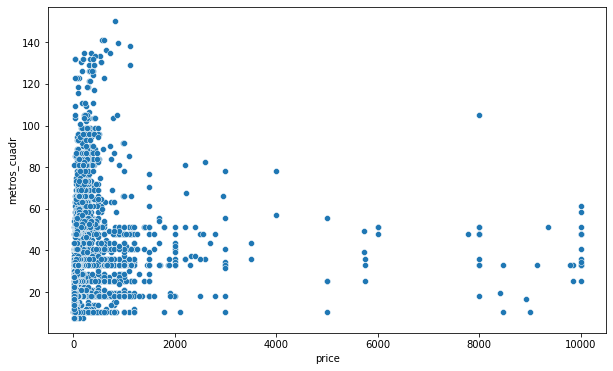

In [22]:
print(df_LIMPIO.shape)

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_LIMPIO, y='metros_cuadr', x='price');

(18271, 30)


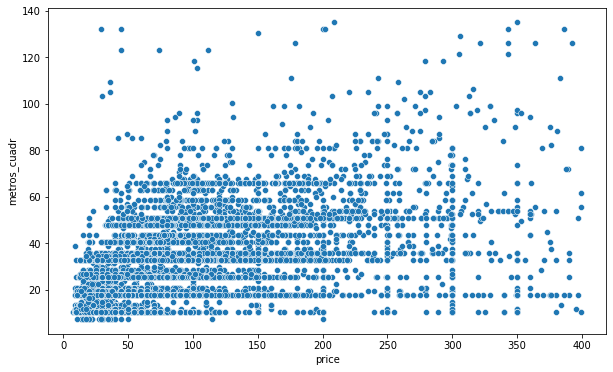

In [23]:
# ELIMINAMOS OUTLIERS DE LA VARIABLE TARGET Y DE LA VARIABLE MÁS CORRELADA.

mask1 = df_LIMPIO['price']>=400
# mask2 = df_LIMPIO['price']>=1000

df_LIMPIO = df_LIMPIO.drop(df_LIMPIO[mask1].index)


# ELIMINAMOS OUTLIERS DE LA VARIABLE TARGET Y DE LA VARIABLE MÁS CORRELADA.

print(df_LIMPIO.shape)
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_LIMPIO, y='metros_cuadr', x='price');


In [24]:
df_LIMPIO.groupby(['price']).sum().sort_values(by='price')

,latitude,longitude,accommodates,bedrooms,beds,review_scores_rating,total_viviendas_host,reviews_per_month,amenities_len,room_type_code,eur_distrito,ranking,dist_p_sol,bathrooms_num,bathrooms_priv_or_shar,facturas_inc,pet,airport,breakfast,wifi,pool,air_cond,elevator,balcony,workspace,nespresso,single_level,host_since_years,metros_cuadr
price,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8.0,80.82071,-7.33743,2,2.0,2.0,200.0,4,0.10,406,100,6810.0,105.116266,8.4,2.0,1,0,0,0,0,2,0,2,1,0,2,0,0,6,21.0
9.0,727.28260,-66.51761,30,20.0,21.0,1129.0,28,4.59,4100,1200,52389.0,966.416523,102.0,22.5,6,6,6,6,7,16,3,4,7,3,9,2,4,93,292.5
10.0,1373.63150,-125.40472,47,45.0,42.0,1243.0,68,8.34,7309,1850,93963.0,1730.581705,213.1,37.0,15,6,6,6,8,25,6,12,10,10,23,4,4,170,463.5
11.0,1172.02404,-107.15401,44,33.0,33.0,1602.0,96,35.01,7667,1450,96650.0,1617.320149,129.6,37.5,4,3,3,3,3,29,2,6,10,3,17,2,3,126,442.5
12.0,2424.44772,-221.16204,77,61.0,69.0,3394.0,138,39.73,14127,3000,172998.0,3139.099980,358.7,64.5,13,15,15,15,15,58,3,17,16,6,30,3,4,301,771.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390.0,161.68713,-14.69734,13,6.0,9.0,0.0,5,0.00,760,500,16225.0,268.731320,12.2,5.0,4,1,1,2,2,4,0,3,3,0,3,0,0,24,112.5
392.0,40.42594,-3.69743,16,6.0,14.0,96.0,5,1.85,766,200,4503.0,68.043894,0.8,2.0,1,0,0,0,0,1,0,1,1,0,1,0,1,7,126.0
395.0,40.44529,-3.69699,1,1.0,1.0,0.0,1,0.00,27,50,4855.0,64.056634,2.4,1.5,1,0,0,0,0,0,0,0,0,0,0,0,0,6,12.0


In [25]:
# HACEMOS UNA NUEVA COLUMNA DE RANGOS DE PRECIOS, PARA CONVERTIR EL PROBLEMA EN UNO DE CLASIFICACIÓN EN VEZ DE REGRESIÓN

df_LIMPIO['rangos_precios'] = df_LIMPIO['price'].copy()

df_LIMPIO.drop(columns=['price'], inplace=True)

In [26]:
# CREAMOS LOS RANGOS ENTRE LOS QUE SE DIVIDIRÁ

for i in range(len(df_LIMPIO['rangos_precios'])):
    if df_LIMPIO['rangos_precios'].iloc[i] <= 50:
        df_LIMPIO['rangos_precios'].iloc[i] = 50

    elif 50 < df_LIMPIO['rangos_precios'].iloc[i] <= 100:
        df_LIMPIO['rangos_precios'].iloc[i] = 100

    elif 100 < df_LIMPIO['rangos_precios'].iloc[i] <= 200:
        df_LIMPIO['rangos_precios'].iloc[i] = 150

    else:
        df_LIMPIO['rangos_precios'].iloc[i] = 200

c:\Users\pieci\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
print(df_LIMPIO['rangos_precios'].nunique())
df_LIMPIO['rangos_precios'].value_counts()

4


50.0     8345
100.0    6276
150.0    2827
200.0     823
Name: rangos_precios, dtype: int64

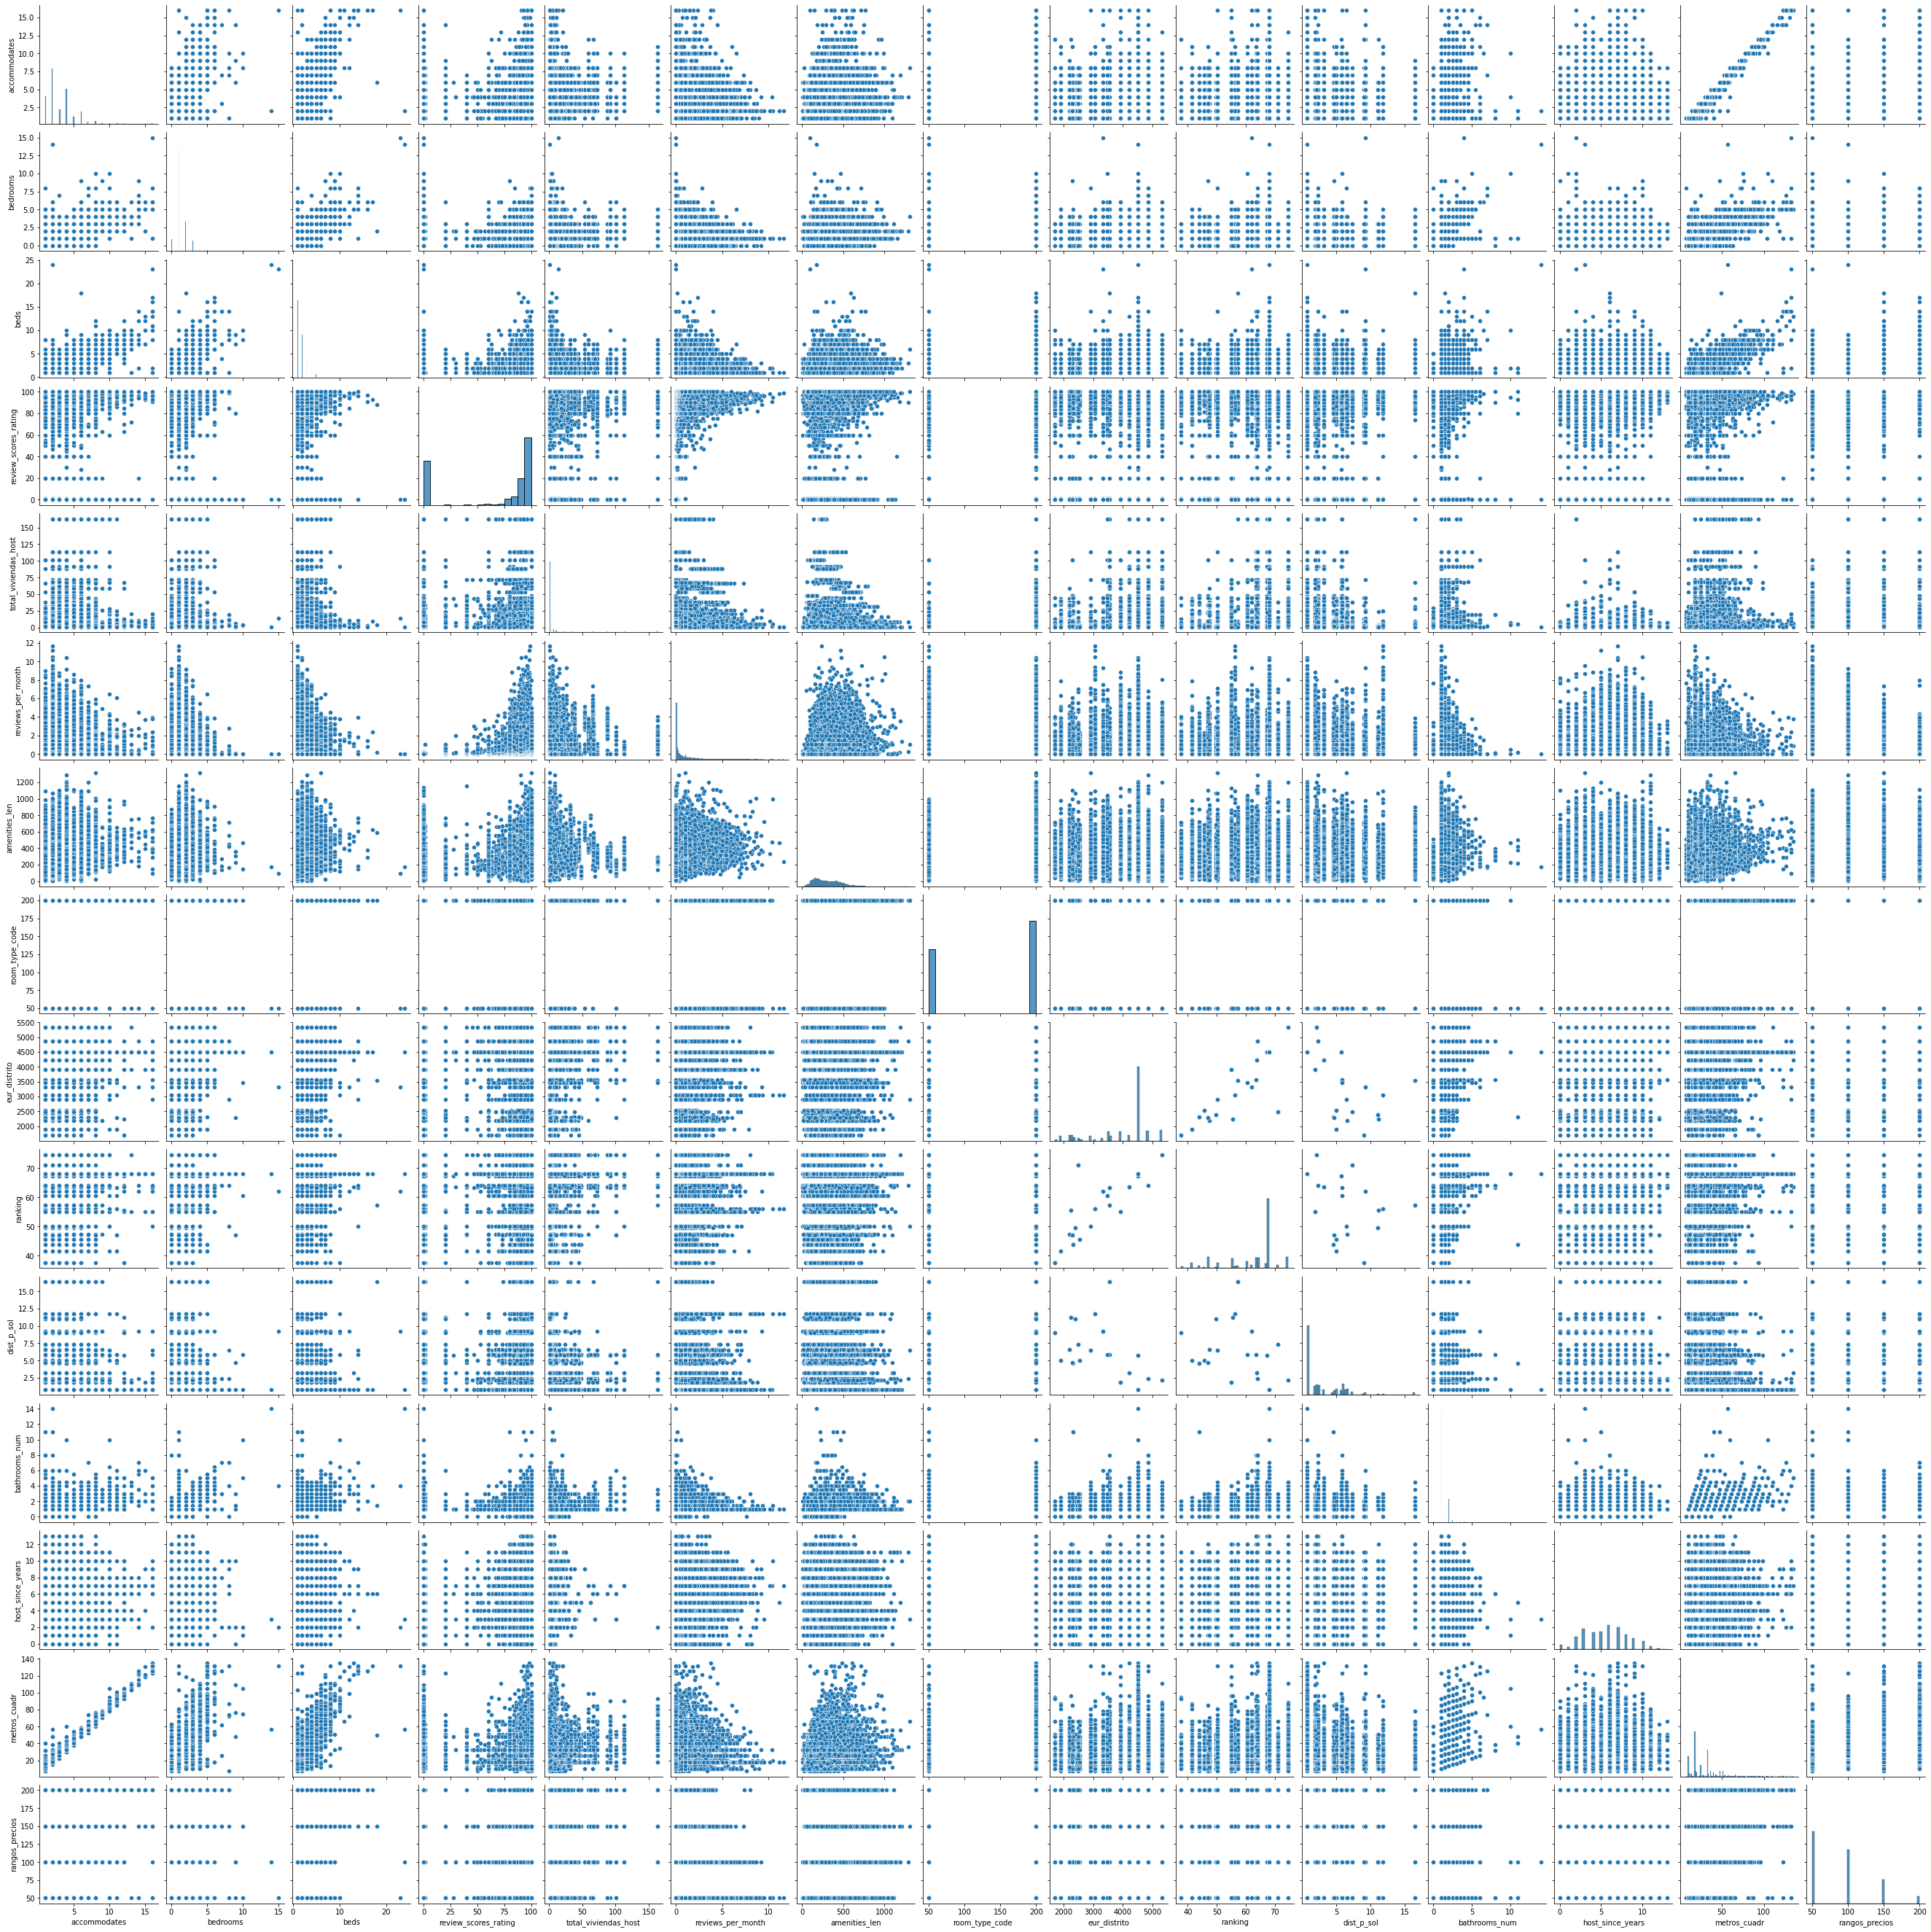

In [28]:
# REDUCIMOS EL DF PARA ESTUDIAR MEJOR SUS RELACIONES ENTRE VARIABLES

df_eda=df_LIMPIO.drop(columns=['bathrooms_priv_or_shar','facturas_inc','pet','airport','breakfast','wifi','pool','air_cond',
'elevator','balcony','workspace','nespresso','single_level']).iloc[:, 2:]

sns.pairplot(df_eda)

In [29]:
df_LIMPIO.to_csv('data/df_LIMPIO_12_09.csv')

In [30]:
df_LIMPIO.head()

,latitude,longitude,accommodates,bedrooms,beds,review_scores_rating,total_viviendas_host,reviews_per_month,amenities_len,room_type_code,eur_distrito,ranking,dist_p_sol,bathrooms_num,bathrooms_priv_or_shar,facturas_inc,pet,airport,breakfast,wifi,pool,air_cond,elevator,balcony,workspace,nespresso,single_level,host_since_years,metros_cuadr,rangos_precios
0,40.45724,-3.67688,2,1.0,1.0,98.0,1,0.58,272,50,4508.0,67.220486,5.8,1.0,0,0,0,1,0,1,0,1,1,0,0,0,0,13,18.0,100.0
1,40.40381,-3.74130,1,1.0,1.0,92.0,2,0.42,444,50,2287.0,47.008319,4.7,1.0,1,0,0,0,0,1,0,1,1,0,1,0,0,12,10.5,50.0
2,40.38840,-3.69511,6,3.0,5.0,0.0,7,0.00,631,200,3917.0,55.025641,1.9,2.0,1,0,0,0,0,1,1,0,1,1,1,0,1,12,51.0,50.0
3,40.42183,-3.70529,3,0.0,1.0,98.0,1,0.13,460,200,4503.0,68.043894,0.8,1.0,1,0,0,0,0,1,0,1,1,0,1,0,0,2,25.5,100.0
4,40.38975,-3.69018,1,1.0,1.0,94.0,1,1.12,215,50,3917.0,55.025641,1.9,1.0,1,0,0,0,0,1,0,0,1,1,0,0,0,12,10.5,50.0


In [31]:
df_LIMPIO.describe()

,latitude,longitude,accommodates,bedrooms,beds,review_scores_rating,total_viviendas_host,reviews_per_month,amenities_len,room_type_code,eur_distrito,ranking,dist_p_sol,bathrooms_num,bathrooms_priv_or_shar,facturas_inc,pet,airport,breakfast,wifi,pool,air_cond,elevator,balcony,workspace,nespresso,single_level,host_since_years,metros_cuadr,rangos_precios
count,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000,18271.000000
mean,40.420776,-3.694720,3.070823,1.318866,1.932790,66.615785,10.461989,0.848417,306.775601,138.689727,3999.252641,62.772208,3.173691,1.272235,0.738821,0.083028,0.082809,0.108642,0.101308,0.945871,0.071315,0.631274,0.499973,0.198511,0.637951,0.054622,0.081222,5.601500,26.847874,89.403974
std,0.022544,0.027900,1.881555,0.844710,1.319913,42.425489,24.145170,1.262129,164.749996,73.742044,943.578378,8.857756,3.110676,0.593059,0.439289,0.275932,0.275601,0.311198,0.301744,0.226279,0.257358,0.482473,0.500014,0.398890,0.480606,0.227247,0.273183,2.591907,14.807746,43.207858
min,40.332210,-3.863910,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,50.000000,1696.000000,37.641618,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000,50.000000
25%,40.409185,-3.707860,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,174.000000,50.000000,3476.000000,57.198083,0.800000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,18.000000,50.000000
50%,40.419350,-3.701210,2.000000,1.000000,2.000000,92.000000,2.000000,0.270000,280.000000,200.000000,4503.000000,68.043894,2.200000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,21.000000,100.000000
75%,40.429910,-3.686295,4.000000,2.000000,2.000000,97.000000,6.000000,1.150000,415.000000,200.000000,4503.000000,68.043894,5.000000,1.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,7.000000,33.000000,100.000000
max,40.562740,-3.531900,16.000000,15.000000,24.000000,100.000000,163.000000,11.670000,1311.000000,200.000000,5328.000000,74.694253,16.400000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,135.000000,200.000000


c:\Users\pieci\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


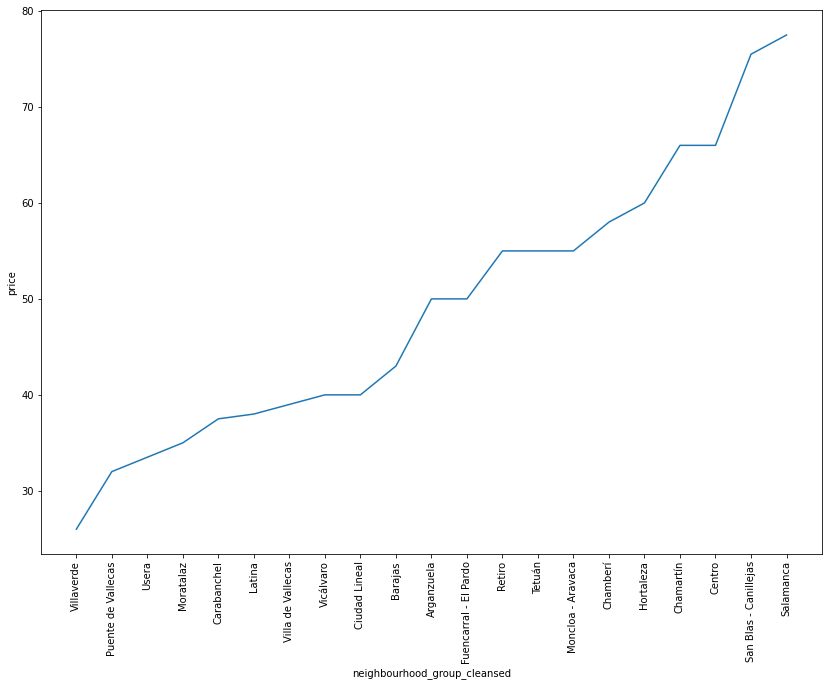

In [32]:
# SEGUIMOS ESTUDIANDO LAS VARIABLES QUE CONSIDERAMOS MÁS IMPORTANTES

precio_distrito = df_listings_detailed[['neighbourhood_group_cleansed', 'price']].groupby('neighbourhood_group_cleansed', as_index=False).median()\
        .sort_values(by='price')

plt.figure(figsize=(14,10))
sns.lineplot(precio_distrito['neighbourhood_group_cleansed'], precio_distrito['price'])
plt.xticks(rotation='vertical');

<AxesSubplot:>

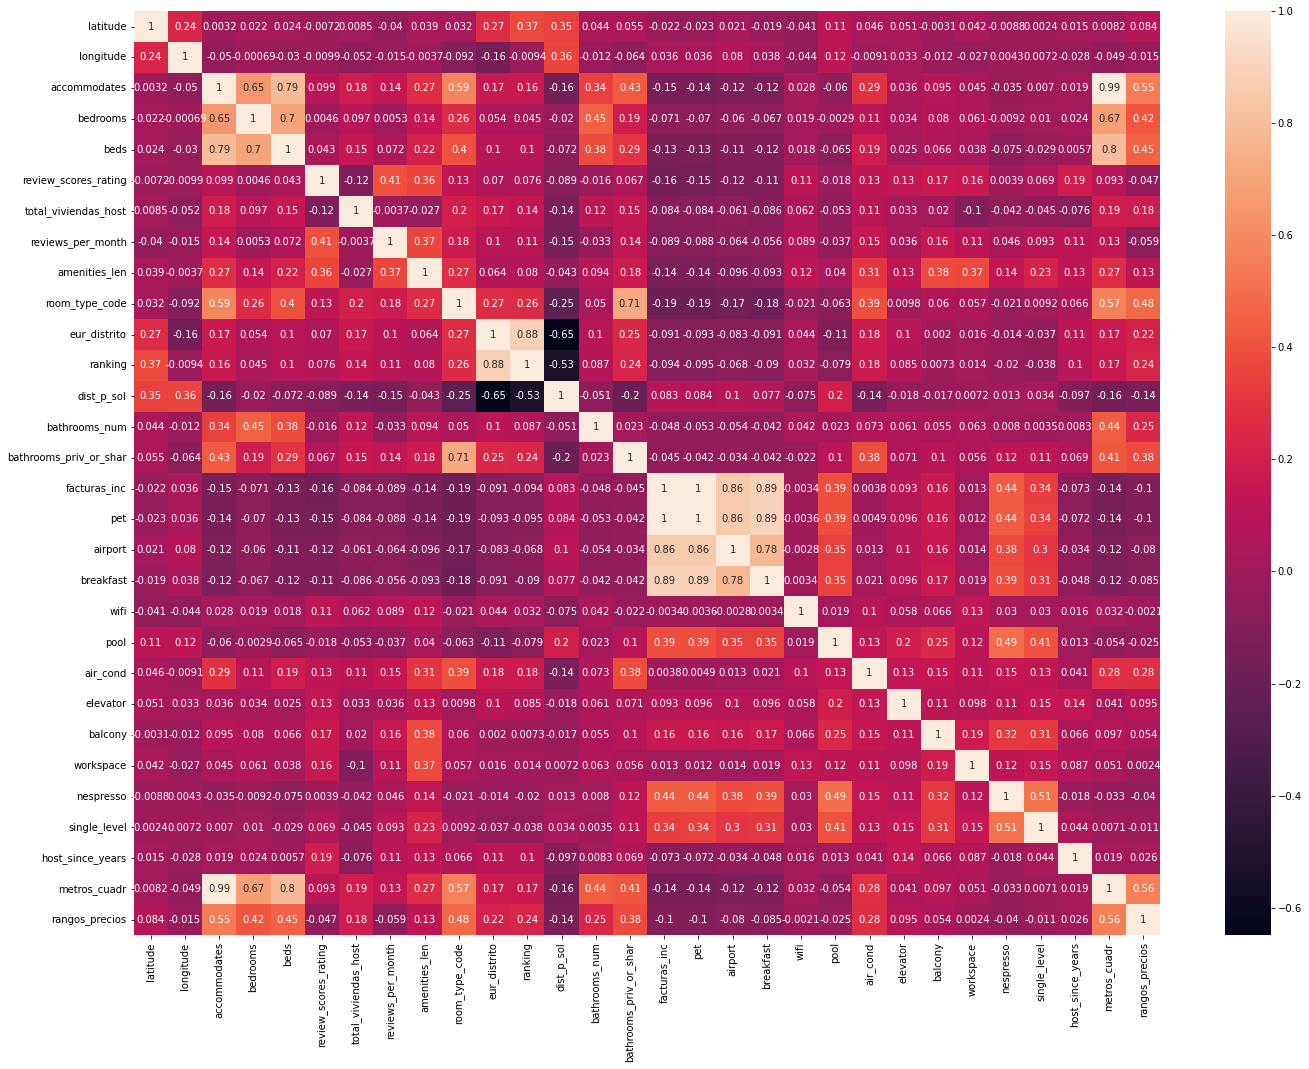

In [33]:
plt.figure(figsize=(23,17))
sns.heatmap(df_LIMPIO.corr(), annot=True)

In [34]:
corr_matrix=df_LIMPIO.corr()
corr_matrix['rangos_precios'].sort_values(ascending=False)

rangos_precios            1.000000
metros_cuadr              0.557016
accommodates              0.553089
room_type_code            0.483450
beds                      0.454425
bedrooms                  0.416653
bathrooms_priv_or_shar    0.380606
air_cond                  0.276512
bathrooms_num             0.249067
ranking                   0.239255
eur_distrito              0.219570
total_viviendas_host      0.182026
amenities_len             0.125340
elevator                  0.094992
latitude                  0.083826
balcony                   0.053930
host_since_years          0.025635
workspace                 0.002391
wifi                     -0.002124
single_level             -0.011479
longitude                -0.014855
pool                     -0.024579
nespresso                -0.040276
review_scores_rating     -0.046723
reviews_per_month        -0.059126
airport                  -0.079853
breakfast                -0.085167
pet                      -0.103043
facturas_inc        

In [35]:
# CON EL DATASET TRANSFORMADO Y LIMPIO, PROCEDEMOS AL MODELADO. EN EL SIGUIENTE PATH 'notebooks/modelos.ipynb' SE PUEDEN ESTUDIAR TODOS LOS 
# MODELOS QUE SE HAN PROBADO.

# EN NUESTRO CASO, HEMOS DECIDIDO TRABAJAR CON RANDOM FOREST CLASSIFIER, YA QUE ES EL QUE MEJOR RESULTADOS NOS HA APORTADO

In [36]:
train = df_LIMPIO.iloc[:-500, :]
test = df_LIMPIO.drop(columns=['rangos_precios']).iloc[-500:, :]

train.to_csv('data/train.csv')
test.to_csv('data/test.csv')

In [37]:
X=df_LIMPIO.drop(columns=['rangos_precios'])
       
y=df_LIMPIO['rangos_precios']

features = list(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.10,
                                                    random_state=42)

In [38]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

# os_us = SMOTETomek()
# X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)

In [39]:
# MODELO DE CLASIFICACIÓN

modelo_rf_cl = RandomForestClassifier(
            n_estimators = 2000,
            class_weight= 'balanced',
            # criterion    = 'gini',
            # max_depth    = 30,
            # max_features = 10,
            # oob_score    = False,
            # n_jobs       = -1,
            # random_state = 123,
            )

            
modelo_rf_cl.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=2000)

In [40]:
## MÉTRICAS DE CLASIFICACIÓN

predictions_rf_cl = modelo_rf_cl.predict(X_test)

print(modelo_rf_cl.score(X_train, y_train))
print(modelo_rf_cl.score(X_test, y_test).round(2))

print('Accuracy:', accuracy_score(y_test, predictions_rf_cl).round(2))
print('Recall:', recall_score(y_test, predictions_rf_cl, average='micro').round(2))
print('Precision:', precision_score(y_test, predictions_rf_cl, average='micro').round(2))


1.0
0.71
Accuracy: 0.71
Recall: 0.71
Precision: 0.71


In [41]:
# LO EXPORTAMOS EN PICKLE PARA LA ENTREGA

from datetime import datetime
import os
import pickle

filename = 'model/modelo_' + datetime.now().strftime("%Y%m%d-%H%M%S")

with open(filename, 'wb') as archivo_salida:
    pickle.dump(modelo_rf_cl, archivo_salida)

In [42]:
# VEMOS QUE TENEMOS UNA ACCURACY DEL 71%

errores = pd.DataFrame(y_test - predictions_rf_cl)

errores = pd.DataFrame(y_test)
errores['predictions_rf_cl'] = predictions_rf_cl
errores['error']= abs(y_test - predictions_rf_cl)

# np.mean(y_test - predictions_rf_cl)

print(errores['error'].mean())
errores.head(10)

16.575492341356675


,rangos_precios,predictions_rf_cl,error
16992,150.0,100.0,50.0
4538,100.0,100.0,0.0
9753,100.0,100.0,0.0
15879,50.0,50.0,0.0
10113,100.0,150.0,50.0
10607,100.0,100.0,0.0
219,150.0,150.0,0.0
10398,150.0,150.0,0.0
9579,50.0,50.0,0.0
9540,150.0,50.0,100.0


In [43]:
# from sklearn.model_selection import cross_val_score

# results_cv_rf = cross_val_score(modelo_rf, X, y, cv=10, scoring='neg_mean_absolute_error')

# print(results_cv_rf)
# print(results_cv_rf.mean())

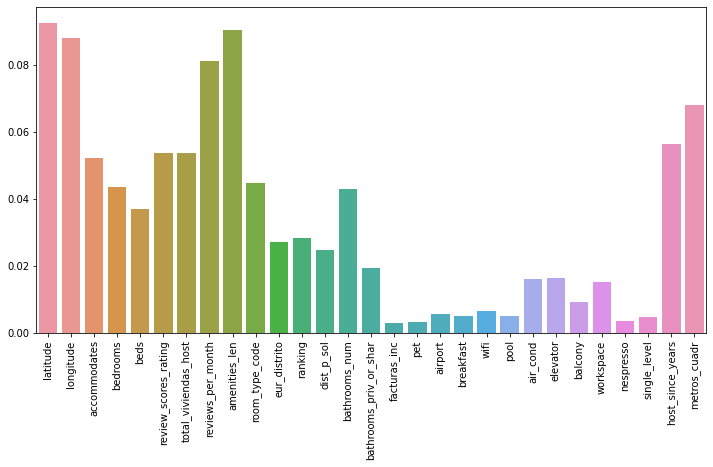

In [44]:
plt.figure(figsize=(12,6))
sns.barplot(x=features, y=modelo_rf_cl.feature_importances_)
plt.xticks(rotation=90);

In [45]:
# LO EXPORTAMOS EN PICKLE PARA PRIMERA ENTREGA

import pickle

filename = 'model/my_model'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(modelo_rf_cl, archivo_salida)

In [46]:
# with open('modelos/Modelo_18_RF', 'rb') as archivo_entrada:
#     loaded_model = pickle.load(archivo_entrada)

In [47]:
# print(loaded_model.score(X_test,y_test))

# loaded_model.predict(X_test)